In [255]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import json

from simple_read_ligo import *

from scipy import signal

# Problem 1 (a)

From the LIGO tutorial:

"The amplitude spectral density (ASDs) are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz).
So, if you want to know the root-mean-square (rms) strain noise in a frequency band,
integrate (sum) the squares of the ASD over that band, then take the square-root."

In [119]:
print(events['GW150914']['fs'])

4096


In [228]:
# ---------------- First, retrieve all data ------------------------------------------

path = 'LOSC_Event_tutorial/LOSC_Event_tutorial'


# Retrieve dictoniary of event details

events = json.load(open(f"{path}/BBH_events_v3.json","r"))


# Retrieve Hanford and Louisiana data as well as the templates

h = []
l = []
templates = []

for i in events.keys():
    h.append(events[i]['fn_H1'])
    l.append(events[i]['fn_L1'])
    templates.append(events[i]['fn_template'])
    fs = events[i]['fs']  # Sampling rate is the same for all events (doesn't matter if it gets overwritten)

# Get relevant information from all events

dt = read_file(f"{path}/{h[0]}")[1]  # dt is the same for all events, so it doesn't matter where I get it from

strain_h = []
strain_l = []
utc = []
th = []
tl = []

for i,c in enumerate(h):
    
    strain_h.append(read_file(f"{path}/{c}")[0])  
    strain_l.append(read_file(f"{path}/{l[i]}")[0])
    
    utc.append(read_file(f"{path}/{l[i]}")[2])  # utc is also the same for h and l
    
    th.append(read_template(f"{path}/{templates[i]}")[0])
    tl.append(read_template(f"{path}/{templates[i]}")[1])
    

template_p = []
template_c = []
    
for i in templates:
    f_template = h5py.File(f"{path}/{i}", "r")

    template_p1, template_c1 = f_template["template"][...]
    
    template_p.append(template_p1)
    template_c.append(template_c1)


In [260]:
# ------------ Next, come up with a noise model ----------------------------------------------

# Use the window function presented in class

def make_window(n):
    ''' From class '''
    x=np.linspace(-np.pi,np.pi,n)
    return 0.5+0.5*np.cos(x)

def make_flat_window(n,m):
    ''' From class. m determines the "flatness" of the window '''
    tmp=make_window(m)
    win=np.ones(n)
    mm=m//2
    win[:mm]=tmp[:mm]
    win[-mm:]=tmp[-mm:]
    return win


n = len(strain_h[0])

win = make_flat_window(n, n//5)

sft = np.fft.rfft(win*strain_h[0])  # Multiply by window function, go to Fourier space

Nft = np.abs(sft)**2  # This is basically the PSD

sft_white = sft/np.sqrt(Nft) # Whiten the data
tft_white = np.fft.rfft(th[0]*win)/np.sqrt(Nft) # Also whiten the template
t_white = np.fft.irfft(tft_white)



# Problem 1 (c)

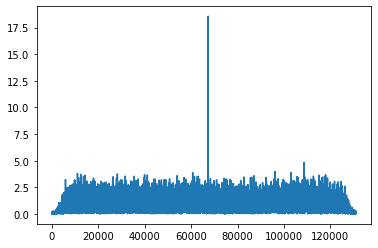

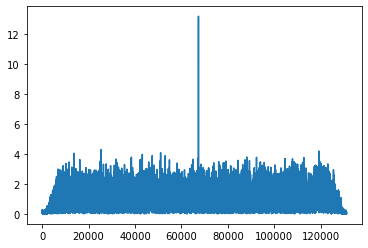

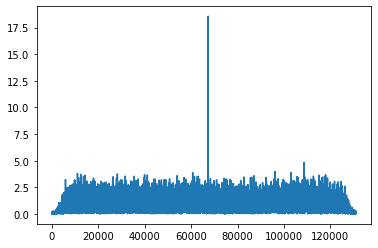

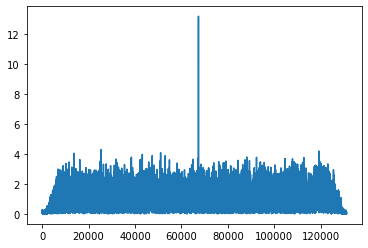

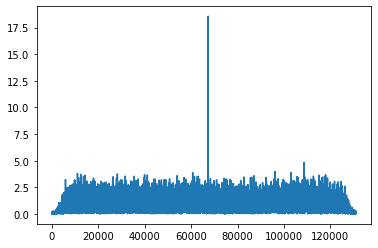

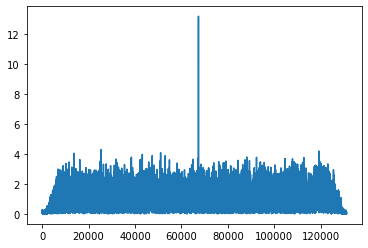

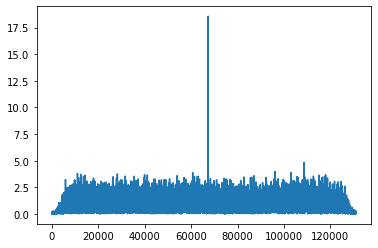

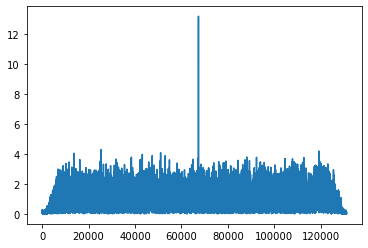

In [261]:
# ----------------------- Use output of matched filter to find SNR -----------------------------------------------

# Inspired from LIGO tutorial

NFFT = 4*fs
NOVL = NFFT/2
n = len(strain_h[0])


# define the complex template, common to both detectors:
template = (template_p[0] + template_c[0]*1.j) 

template_fft = np.fft.fft(template*dwindow) / fs

# Windows
psd_window = np.blackman(NFFT)
dwindow = signal.tukey(template.size, alpha=1./8)

datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])


for k in range(len(strain_h)):

    for i in ['H','L']:
        if i == 'H':
            data = strain_h[0]
            mf = mf_h[0]
        else:
            data = strain_l[0]
            mf = mf_l[0]
        
        # -- Calculate the PSD of the data.  Also use an overlap, and window:
        data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        data_fft = np.fft.fft(data*dwindow) / fs

        # -- Interpolate to get the PSD values at the needed frequencies
        power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = data_fft * template_fft.conjugate() / power_vec
        optimal_time = 2*np.fft.ifft(optimal)*fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data.size / 2)  # location of peak in the template
        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)
    
        plt.plot(SNR)
        plt.show()